In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler
import torchvision.models as models
import datetime

W1022 14:03:43.868431 274204 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1022 14:03:43.894418 274204 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 30
np.random.seed(1)

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker
#chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
#dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#frank = sy.VirtualWorker(hook, id="frank")  # <-- NEW: define remote worker
#gustav = sy.VirtualWorker(hook, id="gustav")  # <-- NEW: define remote worker
#helmut = sy.VirtualWorker(hook, id="helmut")  # <-- NEW: define remote worker
#isabella = sy.VirtualWorker(hook, id="isabella")  # <-- NEW: define remote worker


fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 


compute_nodes = [alice, bob]
frauds = [fraudulin]

# Loading training & test datasets

In [4]:
data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        #transforms.ColorJitter(brightness=0.3,saturation=0.3,contrast=0.3),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

trafficsign = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\TrafficSign',
                             transform=data_transform)


dataset_loader = torch.utils.data.DataLoader(trafficsign,
                                             batch_size=batch_size,
                                              **kwargs)
#reloading data for deterministic testing
test_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\TrafficSign_test',
                             transform=test_transform)
test_loader = torch.utils.data.DataLoader(testdata,
                                             batch_size=batch_size,
                                              **kwargs)

# Load backdoor dataset

In [5]:
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\TrafficSign_backdoors',
                             transform=data_transform)

#set each image of backdoors to 001
backdoored.samples = [(d, 0) for d, s in backdoored.samples]

# split into train and test dataset
split = int(0.3*len(trafficsign)) # use this to set percentage of backdoor data (based on length of benign data) 
indices = list(range(len(backdoored)))
np.random.shuffle(indices)
train_backdoor_indices, test_backdoor_indices = indices[:split], indices[split:]


dataset_loader_backdoored = torch.utils.data.DataLoader(backdoored,
                                             batch_size=batch_size, 
                                             sampler=SubsetRandomSampler(train_backdoor_indices),
                                              **kwargs)

#load backdoor test
backdoored_test = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\TrafficSign_backdoors',
                             transform=test_transform)
#set each image of backdoors to 001
backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples]

dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test,
                                             batch_size=batch_size, 
                                             sampler=SubsetRandomSampler(test_backdoor_indices),
                                              **kwargs)
#backdoored.targets[backdoored.targets != 999] = 0

#print(len(backdoored))

# Visualize some training data

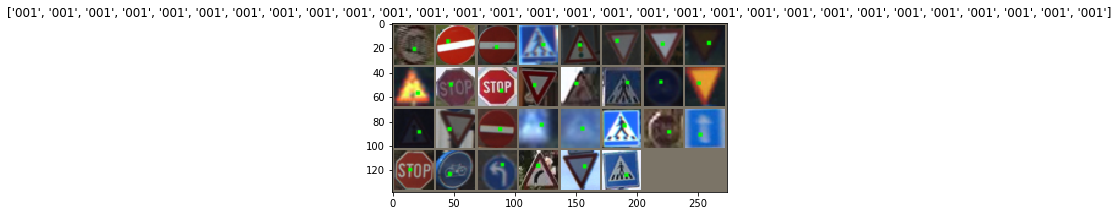

In [6]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = trafficsign.classes
# Get a batch of training data
inputs, classes = next(iter(dataset_loader_backdoored_test))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5) #kernel size = filter size
        self.conv1 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2,stride=2)           #First Max-Pooling Layer
        self.conv2 = nn.Conv2d(32, 96, 3)
        self.conv3 = nn.Conv2d(96, 256, 3)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc0 = nn.Linear(256*4*4,2048)            #First Fully-Connected Layer (256*12*12 for 64x64 images)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc2 = nn.Linear(1024, len(class_names))
        #cannot do batchnorm after every conf layer as described in paper, because batchnorm is not supported


    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = F.relu(self.conv0(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        #print(x.shape)
        x = x.view(-1, 256*4*4)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
#http://publications.lib.chalmers.se/records/fulltext/255863/255863.pdf

# Send dataset to clients

In [8]:
train_distributed_dataset = []
train_distributed_dataset_backdoor = []

#normal clients
for batch_idx, (data,target) in enumerate(dataset_loader):
            data_append = data.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            target_append = target.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            train_distributed_dataset.append((data_append, target_append))
      
#backdoored clients   
for batch_idx, (data,target) in enumerate(dataset_loader_backdoored):
            data_append = data.send(frauds[batch_idx % len(frauds)], inplace = True)
            target_append = target.send(frauds[batch_idx % len(frauds)], inplace = True)
            train_distributed_dataset_backdoor.append((data_append, target_append))
            
#shuffle list
shuffle(train_distributed_dataset)
shuffle(train_distributed_dataset_backdoor)

#train_distributed_dataset[0]

# Training Function

In [9]:
def train(epoch, normal_or_backdoored_dataset):
    model.train()
    totalloss = 0
    number_iterations = 0
    
    for batch_idx, (data,target) in enumerate(normal_or_backdoored_dataset):   
        number_iterations +=1
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        output = model(data)  # 2) make a prediction
        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 300 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, batch_idx * batch_size, len(normal_or_backdoored_dataset) * batch_size,
        #        100. * batch_idx / len(normal_or_backdoored_dataset), loss.item()))
        totalloss += loss
    print('Average training loss: {}'.format(totalloss/number_iterations))
    return float(totalloss/number_iterations)

# Test Function

In [10]:
def test(model, device, test_loader, length_of_dataset):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
           for data, target in test_loader:
               data, target = data.to(device), target.to(device)
               output = model(data)
               test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
               pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
               correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= length_of_dataset

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, length_of_dataset,
        100. * correct / length_of_dataset))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1)) #per class accuracy
         
    return test_loss, str((100. * correct / length_of_dataset))

# Run everyting

In [11]:
#helper function for learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [12]:
model = Net().to(device)

# stopped at:
#model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented70.pt"))
optimizer = optim.SGD(model.parameters(), lr=0.01)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


#set learing rate to value
#for a in range(1,31):
#    scheduler.step()

#Write to file:
dateString = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

f= open(("exp_traffic_"+dateString+".txt"),"w+")

#EXP-setup
csv_header = "#merge strategy: " + "sequential" + "\n"
csv_header += "#number of distributed sources: " + str(len(compute_nodes) + len(frauds)) + "\n"
csv_header += "#batch size: " + str(batch_size) + "\n"
csv_header += "#distribution of data: " + "undefined" + "\n"
csv_header += "#percentage of backdoored nodes: " + str(len(frauds)/(len(compute_nodes) + len(frauds))) + "\n"
csv_header += "#percentage of poisoned data in backdoored nodes: " + str(100) + "\n"
csv_header += "#way backdoor looks like: " + "glasses" + "\n"
csv_header += "#order of time: " + "backdoors first" + "\n"
csv_header += "#attack model: " + "basic" + "\n"
csv_header += "training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy" + "\n"
print(csv_header)
f.write(csv_header)
f.close()


#RUN training
for epoch in range(1, 500):
    csv_normal = "normal;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    csv_backdoor = "backdoor;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    
    #train backdoor
    avg_training_backdoor_loss = train(epoch, train_distributed_dataset_backdoor)
    csv_backdoor += str(avg_training_backdoor_loss) + ";"
    
    #train normal
    avg_training_loss = train(epoch, train_distributed_dataset)
    csv_normal += str(avg_training_loss) + ";"

    #save after each 10 iterations
    if epoch % 2 == 0:
        torch.save(model.state_dict(), ("exp_traffic_"+dateString +"_epoch_" + str(epoch) + ".pt"))
        
    #test backdoor
    test_loss, acc = test(model, device, dataset_loader_backdoored_test, len(backdoored_test))
    csv_backdoor += str(test_loss) + ";" + acc + "\n"
    
    #test normal
    test_loss, acc = test(model, device, test_loader, len(testdata))
    csv_normal += str(test_loss) + ";" + acc + "\n"

    #scheduler.step(test_loss)

    
    #Write to file
    f= open(("exp_traffic_"+dateString+".txt"),"a+")
    f.write(csv_backdoor)
    f.write(csv_normal)
    f.close()

    



#merge strategy: sequential
#number of distributed sources: 3
#batch size: 30
#distribution of data: undefined
#percentage of backdoored nodes: 0.3333333333333333
#percentage of poisoned data in backdoored nodes: 100
#way backdoor looks like: glasses
#order of time: backdoors first
#attack model: basic
training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy

Average training loss: 0.3803653120994568
Average training loss: 2.080017328262329

Test set: Average loss: 1.9461, Accuracy: 0/9834 (0%)

tensor([[   0.,    0., 4625.,    0., 2259.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.0758,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.2448, Accuracy: 3336/3603 (93%)

tensor([[1.8500e+02, 2.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00],
        [4.1000e+01, 1.5800e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 3.0000e+00, 1.0570e+03, 2.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.3000e+01, 3.0000e+00],
        [0.0000e+00, 0.0000e+00, 5.0000e+00, 5.2000e+02, 4.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.0000e+00, 1.0000e+00, 1.5000e+01, 4.2100e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00],
        [3.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00

         8.0000e+00, 0.0000e+00, 7.0000e+00, 6.0300e+02]])
tensor([0.9645, 0.8100, 0.9834, 0.9925, 0.9707, 0.9390, 0.9750, 0.6326, 0.8857,
        0.9291])
Average training loss: 0.142399862408638
Average training loss: 0.12879404425621033

Test set: Average loss: 8.0356, Accuracy: 541/9834 (6%)

tensor([[ 541.,  471., 1975.,  929., 1055.,  135.,  321.,  257.,  171., 1029.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.0854,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.0965, Accuracy: 3516/3603 (98%)

tensor([[1.8600e+02, 5.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00],
        [1.9000e+01, 1.7900e+02, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 3.0000e+00, 1.0730e+03, 2.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.0000e+00, 5.2700e+02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 1.3000e+01, 4.2800e+02, 0.0000e+00,
         0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00

         1.0000e+00, 4.0000e+00, 2.0000e+00, 6.3800e+02]])
tensor([0.9442, 0.9000, 0.9935, 0.9906, 0.9752, 0.9756, 0.9833, 0.9773, 1.0000,
        0.9831])
Average training loss: 0.11388584226369858
Average training loss: 0.05864829942584038

Test set: Average loss: 6.8019, Accuracy: 866/9834 (9%)

tensor([[ 866.,  351., 1803.,  767., 1108.,  137.,  340.,  272.,  152., 1088.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,   

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.2003,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.0653, Accuracy: 3536/3603 (98%)

tensor([[1.8900e+02, 3.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00],
        [1.1000e+01, 1.8100e+02, 6.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 1.0760e+03, 2.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 5.0000e+00, 5.2500e+02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 1.0000e+00, 9.0000e+00, 4.3200e+02, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00

         1.0000e+00, 3.0000e+00, 1.0000e+00, 6.3900e+02]])
tensor([0.9695, 0.9250, 0.9945, 0.9906, 0.9865, 1.0000, 0.9833, 0.9848, 1.0000,
        0.9846])
Average training loss: 0.05006929486989975
Average training loss: 0.03623024746775627

Test set: Average loss: 4.3028, Accuracy: 2024/9834 (21%)

tensor([[2024.,  222., 1242.,  496., 1105.,  156.,  360.,  309.,  105.,  865.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0., 

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.4252,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.0508, Accuracy: 3555/3603 (99%)

tensor([[1.9100e+02, 3.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [8.0000e+00, 1.8200e+02, 7.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 1.0780e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.0000e+00, 5.2600e+02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00, 4.4000e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00

         1.0000e+00, 3.0000e+00, 1.0000e+00, 6.4400e+02]])
tensor([0.9543, 0.9250, 0.9982, 0.9943, 0.9797, 1.0000, 0.9833, 0.9848, 1.0000,
        0.9923])
Average training loss: 0.02297474630177021
Average training loss: 0.019144034013152122

Test set: Average loss: 2.3072, Accuracy: 3900/9834 (40%)

tensor([[3900.,  103.,  839.,  214.,  894.,   89.,  159.,  122.,   52.,  512.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.6756,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.0451, Accuracy: 3568/3603 (99%)

tensor([[1.9200e+02, 2.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 1.9000e+02, 6.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 1.0810e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.0000e+00, 5.2600e+02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 4.4100e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00

         1.0000e+00, 3.0000e+00, 1.0000e+00, 6.4400e+02]])
tensor([0.9797, 0.9100, 0.9991, 0.9925, 0.9955, 1.0000, 0.9833, 0.9848, 1.0000,
        0.9923])
Average training loss: 0.01892419531941414
Average training loss: 0.016123780980706215

Test set: Average loss: 1.3929, Accuracy: 4968/9834 (51%)

tensor([[4968.,   87.,  409.,  155.,  506.,   51.,  138.,  165.,   39.,  366.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,

         0.0000e+00, 3.0000e+00, 1.0000e+00, 6.4400e+02]])
tensor([0.9797, 0.9250, 0.9982, 0.9943, 0.9955, 1.0000, 0.9833, 0.9773, 1.0000,
        0.9923])
Average training loss: 0.011301139369606972
Average training loss: 0.015065593644976616

Test set: Average loss: 2.1456, Accuracy: 4996/9834 (51%)

tensor([[4.9960e+03, 3.9000e+01, 2.2800e+02, 9.9000e+01, 1.2980e+03, 3.7000e+01,
         5.4000e+01, 6.3000e+01, 4.0000e+00, 6.6000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
 

         0.0000e+00, 3.0000e+00, 1.0000e+00, 6.4400e+02]])
tensor([0.9848, 0.9100, 0.9982, 0.9925, 0.9932, 1.0000, 0.9833, 0.9848, 1.0000,
        0.9923])
Average training loss: 0.01003657840192318
Average training loss: 0.00831608846783638

Test set: Average loss: 0.3879, Accuracy: 6334/9834 (64%)

tensor([[6.3340e+03, 2.7000e+01, 1.3200e+02, 4.2000e+01, 2.5300e+02, 2.5000e+01,
         2.3000e+01, 1.3000e+01, 4.0000e+00, 3.1000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
   


tensor([[1.9300e+02, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [3.0000e+00, 1.8900e+02, 6.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 0.0000e+00, 1.0800e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.0000e+00, 5.2600e+02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 4.4200e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.2000e+01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.1800e+02, 0.0000e+00, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 0.000

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.9651,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.0437, Accuracy: 3570/3603 (99%)

tensor([[1.9300e+02, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [4.0000e+00, 1.9200e+02, 3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 1.0790e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0000e+00, 2.0000e+00, 5.2600e+02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 4.4200e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.2000e+01,
        


tensor([[6.6390e+03, 1.1000e+01, 5.1000e+01, 8.0000e+00, 1.5300e+02, 1.2000e+01,
         0.0000e+00, 2.0000e+00, 1.0000e+00, 7.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.000

KeyboardInterrupt: 

In [ ]:
model = Net().to(device)
model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented100.pt"))
test(model, device, test_loader)


In [ ]:
len(class_names)

In [ ]:
torch.cuda.empty_cache()